In [96]:
import pysam
import matplotlib.pyplot as plt
import ternary
import numpy as np
from scipy.stats import chi2
import pandas as pd
import joblib

import numpy as np
from scipy.stats import chi2

def chi_sq_hwe(X, x_linked=False, pvalues=True):
    if isinstance(X, np.ndarray) and X.ndim == 1:
        X = np.reshape(X, (1, len(X)))
    if not x_linked:
        # autosomal
        X = X[:, np.argsort(np.sum(X, axis=0))]  # order.auto function equivalent
        n = np.sum(X, axis=1)
        nA = 2 * X[:, 0] + X[:, 1]
        nB = 2 * X[:, 2] + X[:, 1]
        chi = (4 * X[:, 0] * X[:, 2] - X[:, 1]**2) / (nA * nB)
        if pvalues:
            stat = chi2.sf(n * chi**2, 1)  # pchisq function equivalent
        else:
            stat = n * chi**2
    else:
        # X chromosomal
        X = X[:, np.argsort(X[0])]  # order.x function equivalent
        nm = X[:, 0] + X[:, 1]
        nA = X[:, 0] + 2 * X[:, 2] + X[:, 3]
        nA2 = nA**2
        nf = X[:, 2] + X[:, 3] + X[:, 4]
        nt = nm + 2 * nf
        nB = nt - nA
        nB2 = nB**2
        m_num = nA * X[:, 1] - nB * X[:, 0]
        X_male = (m_num**2) / (nm * nA * nB)
        f_num = nt**2 * (X[:, 2]**2 * nB2 + 0.5 * X[:, 3]**2 * nA * nB + X[:, 4]**2 * nA2) - nf**2 * nA2 * nB2
        X_female = f_num / (nf * nA2 * nB2)
        if pvalues:
            stat = chi2.sf(X_male + X_female, 2)
        else:
            stat = X_male + X_female
    return stat

def parse_vcf(vcf_file):
    vcf = pysam.VariantFile(vcf_file)
    genotype_counts = []
    for record in vcf:
        if record.chrom == 'chrX' or record.chrom == 'chrY':
            continue
        hom_ref, het, hom_alt = 0, 0, 0
        for sample in record.samples.values():
            if None in sample['GT']:
                continue
            ac = sample['GT'].count(1)
            if ac == 0:
                hom_ref += 1
            elif ac == 1:
                het += 1
            elif ac == 2:
                hom_alt += 1
        genotype_counts.append((hom_ref, het, hom_alt))
    return genotype_counts

def calculate_genotype_frequencies(genotype_counts, p_values, alpha=0.05):
    accept_genotype_frequencies = []
    reject_genotype_frequencies = []
    for (hom_ref, het, hom_alt, missing), pval in zip(genotype_counts, p_values):
        total = hom_ref + het + hom_alt
        if total == 0 or missing / (total + missing) >= 0.1:
            continue

        freq_hom_ref = hom_ref / total
        freq_het = het / total
        freq_hom_alt = hom_alt / total
        if pval <= alpha:
            reject_genotype_frequencies.append((freq_hom_ref, freq_het, freq_hom_alt))
        else:
            accept_genotype_frequencies.append((freq_hom_ref, freq_het, freq_hom_alt))
    return accept_genotype_frequencies, reject_genotype_frequencies

def hwe_ternary(genotype_counts, alpha=0.05, title=""):    
    pvals = chi_sq_hwe(genotype_counts[:,:3].astype(int))
    ref_mon = np.isnan(pvals)
    
    m_tot = genotype_counts.sum(axis=1)
    missing_rate = genotype_counts[:,3] / m_tot
    high_missing = missing_rate >= 0.1
    
    filt = pvals[~ref_mon & ~high_missing]
    analyzed = len(filt)
    hwe_pass = (filt>=alpha).sum()

    ret = pd.DataFrame([[len(genotype_counts), 
                     ref_mon.sum(), 
                     high_missing.sum(),
                     analyzed,
                     hwe_pass,
                    hwe_pass / analyzed]], 
                    columns=['Total', 'RefMon', "Missing", "Analyzed", "PassHWE", "Pass%"])
    
    green_genotype_frequencies, red_genotype_frequencies = calculate_genotype_frequencies(genotype_counts, pvals, alpha)
    # Set up the figure and axes
    figure, tax = ternary.figure(scale=1.0)
    tax.boundary(linewidth=2.0)
    tax.gridlines(multiple=0.1, color="blue")

    # Define the vertices of the triangle
    tax.left_axis_label("p^2", offset=0.08)
    tax.right_axis_label("q^2", offset=0.08)
    tax.bottom_axis_label("2pq", offset=0.05)
    
    tax.left_corner_label("REF", offset=0.20)
    tax.top_corner_label("HET", offset=0.13)
    tax.right_corner_label("HOM", offset=0.20)

    # Plot a Hardy-Weinberg Equilibrium line
    p_values = [i/100.0 for i in range(101)]
    points = [(p**2, 2*p*(1-p), (1-p)**2) for p in p_values]
    tax.plot(points, linewidth=3.0, color='black')

    # Add points for variants
    tax.scatter(green_genotype_frequencies, marker='o', color='green', s=10, alpha=0.75)
    tax.scatter(red_genotype_frequencies, marker='o', color='red', s=10, alpha=0.75)

    # Customize the plot
    tax.set_title(title)
    tax.get_axes().axis('off')
    tax.clear_matplotlib_ticks()

    # Show the plot
    plt.show()
    
    return ret

/var/folders/fy/lkd5_yz90zq3f67qys3tpztc0000gn/T/ipykernel_3549/362858767.py:21: RuntimeWarning: invalid value encountered in divide
  chi = (4 * X[:, 0] * X[:, 2] - X[:, 1]**2) / (nA * nB)
/Users/english/py/lib/python3.9/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


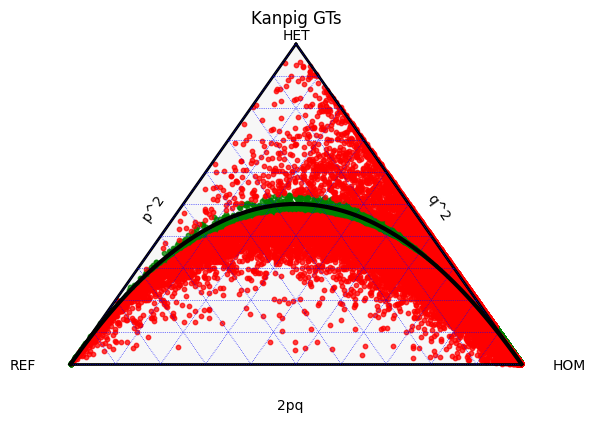

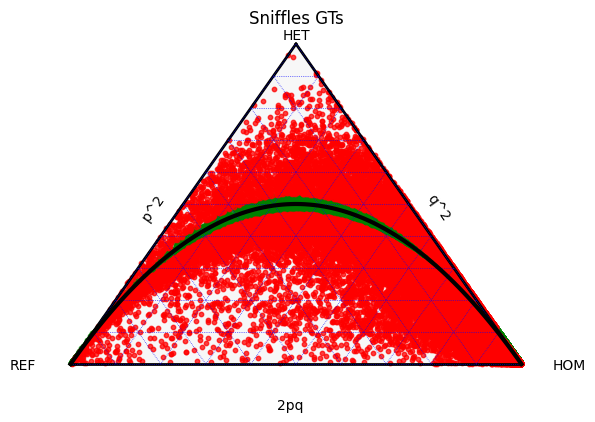

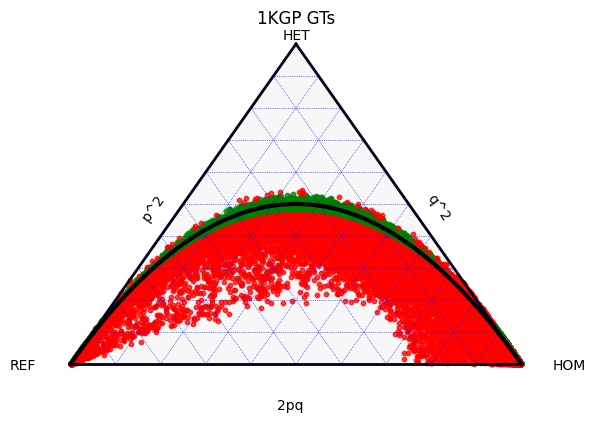

In [97]:
gt_kanpig = joblib.load("gtcnt_kanpig.jl")
a = hwe_ternary(gt, title="Kanpig GTs")

gt_snif = joblib.load("gtcnt_snifmerge.jl")
b = hwe_ternary(gt_snif, title="Sniffles GTs")

gt_1kgp = joblib.load("1kgp_ont.jl")
c = hwe_ternary(gt_1kgp, title="1KGP GTs")


In [99]:
df = pd.concat([a, b, c])
df['program'] = ['kanpig', 'sniffles', '1kgp']
df.set_index('program')

,Total,RefMon,Missing,Analyzed,PassHWE,Pass%
program,,,,,,
kanpig,3424358,2003591,622796,1268360,1047960,0.826232
sniffles,1204380,22687,396631,792606,567304,0.715745
1kgp,163466,656,0,162810,116269,0.714139


In [95]:
df

,Total,RefMon,Missing,Analyzed,PassHWE,Pass%
kanpig,3424358.0,2003591.0,622796.0,1268360.0,1047960.0,0.826232
sniffles,1204380.0,22687.0,396631.0,792606.0,567304.0,0.715745
1kgp,163466.0,656.0,0.0,162810.0,116269.0,0.714139


In [74]:
pvals = chi_sq_hwe(gt[:,:3].astype(int))
ref_mon = np.isnan(pvals)

m_tot = gt.sum(axis=1)
missing_rate = gt[:,3] / m_tot
high_missing = missing_rate >= 0.1

filt = pvals[~ref_mon & ~high_missing]

hwe_pass = (filt>=0.5).sum()

/var/folders/fy/lkd5_yz90zq3f67qys3tpztc0000gn/T/ipykernel_3549/693844934.py:21: RuntimeWarning: invalid value encountered in divide
  chi = (4 * X[:, 0] * X[:, 2] - X[:, 1]**2) / (nA * nB)


In [77]:
len(pvals), len(gt), ref_mon.sum(), missing

(3424358, 3424358, 2003591)

In [79]:
high_missing = missing_rate >= 0.1

In [80]:
high_missing.sum()

622796

In [87]:
len(pvals[~ref_mon & ~high_missing]), len(pvals[~(ref_mon | high_missing)])

(1268360, 1268360)

In [88]:
1047960/ 1268360

0.8262322999779242

In [82]:
pvals[ref_mon | high_missing]

array([nan, nan, nan, ..., nan, nan, nan])